In [1]:
import os

def check_new_instance():
    return not os.path.exists('/content/working_dir')

NEW_INSTANCE = check_new_instance()
FORCE_RELOAD = True
DATA_LOADED = True

In [2]:
if NEW_INSTANCE or FORCE_RELOAD:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Install required libraries
    !pip install tensorflow gensim

    # Unzip working directory
    !unzip -q /content/drive/MyDrive/inzynierka_projekt/data.zip -d /content/working_dir

    DATA_LOADED = False
    TESTING = True
    LOAD_MODEL = True

Mounted at /content/drive


In [3]:

if not DATA_LOADED:

  import os
  import numpy as np
  import pickle
  import tensorflow as tf
  import random
  from tensorflow.keras.preprocessing.image import load_img, img_to_array

  def load_preprocessed_captions(file_path):
      with open(file_path, 'rb') as file:
          return pickle.load(file)

  def preprocess_image(image_path, target_size):
      # Load the image file
      image = tf.io.read_file(image_path)
      # Decode the image
      image = tf.image.decode_jpeg(image, channels=3)
      # Resize the image
      image = tf.image.resize(image, target_size[:2])
      # Normalize the image to [-1, 1]
      image = (image / 127.5) - 1.0
      return image

  def create_dataset(image_paths, captions, batch_size, image_size):
      image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
      caption_ds = tf.data.Dataset.from_tensor_slices(captions)
      image_ds = image_ds.map(lambda x: preprocess_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
      return tf.data.Dataset.zip((image_ds, caption_ds)).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

  # Set the working directory
  working_dir = '/content/working_dir/datapreprocessing'
  os.chdir(working_dir)

  # File paths
  image_folder = 'celeba'  # Image folder path
  preprocessed_captions_file = 'preprocessed_data.pkl'  # Text data path

  # Load preprocessed captions
  preprocessed_captions = load_preprocessed_captions(preprocessed_captions_file)

  # Randomly select 5 samples for testing
  sample_keys = list(preprocessed_captions.keys())
  random.shuffle(sample_keys)
  test_sample_keys = sample_keys[:5]

  test_image_paths = [os.path.join(image_folder, key) for key in test_sample_keys]
  test_captions = [preprocessed_captions[key] for key in test_sample_keys]

  BATCH_SIZE = 64
  IMAGE_SIZE = (64, 64, 3)

  # Create the test dataset
  test_dataset = create_dataset(test_image_paths, test_captions, BATCH_SIZE, IMAGE_SIZE)

  # Create lists for training data, excluding the test samples
  train_image_paths = []
  train_captions = []
  for key, caption in preprocessed_captions.items():
      image_path = os.path.join(image_folder, key)
      if key not in test_sample_keys:
          train_image_paths.append(image_path)
          train_captions.append(caption)

  # Create the training dataset
  train_dataset = create_dataset(train_image_paths, train_captions, BATCH_SIZE, IMAGE_SIZE)


  DATA_LOADED = True

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Reshape, Concatenate, Conv2D, BatchNormalization, LeakyReLU



# Define the sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Load pre-created embedding matrix
with open('embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = pickle.load(file)

# Set parameters
vocab_size, embedding_dim = embedding_matrix.shape
max_caption_length = 55
z_dim = 2048

# Textual input and processing
text_input = Input(shape=(max_caption_length,), name='text_input')
text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, input_length=max_caption_length)(text_input)
text_flatten = Flatten()(text_embedding)

# Adjust the number of units in the dense layer to match the image shape for concatenation
dense_units = IMAGE_SIZE[0] * IMAGE_SIZE[1]
text_dense = Dense(dense_units, activation='relu')(text_flatten)
text_reshaped = Reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))(text_dense)

# Image input
image_input = Input(shape=IMAGE_SIZE, name='image_input')

# Concatenate text and image inputs
concatenated = Concatenate(axis=-1)([image_input, text_reshaped])

# Encoder Conv2D layers
x = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(concatenated)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=1024, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=2048, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

fc_shape = K.int_shape(x)[1:]  # Shape before flattening

# Flatten the output of the last Conv2D layer
x = Flatten()(x)

# Bottleneck layers for the mean and log variance of z
z_mean = Dense(2048, name='z_mean')(x)
z_log_var = Dense(2048, name='z_log_var')(x)

z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs=[image_input, text_input], outputs=[z_mean, z_log_var, z, text_dense], name="encoder")

In [5]:
from tensorflow.keras.layers import UpSampling2D, Activation

# Define the dimensionality of the latent space and the shape of the fully connected layer

# Define the decoder
decoder_z_input = Input(shape=(z_dim,), name='z_input')
decoder_text_input = Input(shape=(4096,), name='text_input')
decoder_concatenate = Concatenate()([decoder_z_input, decoder_text_input])

# Map the combined latent and text vector back to the shape before flattening in the encoder
decoder_dense = Dense(np.prod(fc_shape), activation='relu')(decoder_concatenate)
x = Reshape(target_shape=fc_shape)(decoder_dense)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=2048, kernel_size=5, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=1024, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


# Final Conv2D layer to get back to the original image depth
decoded_output = Conv2D(filters=3, kernel_size=5, padding='same')(x)
decoded_output = Activation('tanh')(decoded_output)

# Define the decoder model
decoder = Model(inputs=[decoder_z_input, decoder_text_input], outputs=decoded_output, name='decoder')

In [6]:
from tensorflow.keras.utils import Progbar
from tensorflow.keras.applications import EfficientNetB6

class ConditionalVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, z_dim, **kwargs):
        super(ConditionalVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.z_dim = z_dim
        self.feature_extractor = self.build_efficientnet_feature_extractor()


    def build_efficientnet_feature_extractor(self, input_shape=(224, 224, 3)):
        efficientnet = EfficientNetB6(include_top=False, weights='imagenet', input_shape=input_shape)

        # Set trainable to False for all layers
        for layer in efficientnet.layers:
          layer.trainable = False

        # Layers used for feature extraction
        layer_names = [
            'block2a_expand_conv',  # Low-level features
            'block4a_expand_conv',  # Mid-level features
            'block7a_expand_conv'   # High-level features
        ]

        layers_output = [efficientnet.get_layer(name).output for name in layer_names]
        return Model(inputs=efficientnet.input, outputs=layers_output)

    def build_custom_weights_feature_extractor(self, input_shape=(64,64,3)):
        efficientnet = EfficientNetB6(include_top=False, weights=None, input_shape=(input_shape))
        weights_path = '/content/drive/MyDrive/inzynierka_projekt/classificator/classificator_b7'
        efficientnet.trainable = False
        print(efficientnet.trainable_weights)
        # Load the weights into the base model, skip unrecognized layers
        efficientnet.load_weights(weights_path)

        for layer in efficientnet.layers:
          layer.trainable = False

        # Layers used for feature extraction
        layer_names = [
            'block2a_expand_conv',
            'block3a_expand_conv',
            'block4a_expand_conv',
            'block6a_expand_conv',
            'block7a_expand_conv'
        ]

        layers_output = [efficientnet.get_layer(name).output for name in layer_names]
        return Model(inputs=efficientnet.input, outputs=layers_output)

    def preprocess_images(self, images):
        # Normalize images to the range expected by EfficientNet
        images_normalized = (images + 1.0) * 127.5

        # Resize images from 64x64 to 224x224
        images_resized = tf.image.resize(images_normalized, [224, 224], method=tf.image.ResizeMethod.BICUBIC)

        return images_resized

        # EfficientNetB6 was designed to accept images in range [0,255]
    def preprocess_images_for_custom(self, images):
        images_normalized = (images + 1.0) * 127.5
        return images

    def compile(self, optimizer, perceptual_loss_factor, reconstruction_loss_factor, kl_loss_factor, **kwargs):
        super(ConditionalVAE, self).compile(optimizer=optimizer, **kwargs)
        self.perceptual_loss_factor = perceptual_loss_factor
        self.reconstruction_loss_factor = reconstruction_loss_factor
        self.kl_loss_factor = kl_loss_factor

    def train_step(self, data):
        images, text = data  # Unpack the data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, reconstructed = self([images, text], training=True)

            # Preprocess images and reconstructed images for EfficientNet
            images_preprocessed = self.preprocess_images(images)
            reconstructed_preprocessed = self.preprocess_images(reconstructed)

            # Extract features from two layers using EfficientNetB0
            real_features_list = self.feature_extractor(images_preprocessed)  # Returns a list of feature maps
            reconstructed_features_list = self.feature_extractor(reconstructed_preprocessed)  # Returns a list of feature maps

            # Perceptual loss for each set of features
            perceptual_loss = 0
            for real_features, reconstructed_features in zip(real_features_list, reconstructed_features_list):
                perceptual_loss += tf.reduce_mean(tf.square(real_features - reconstructed_features))

            # Scale perceptual loss
            perceptual_loss = self.perceptual_loss_factor * perceptual_loss

            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(tf.square(images - reconstructed))

            # Scale reconstruction loss
            reconstruction_loss = self.reconstruction_loss_factor * reconstruction_loss

            # KL loss
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

            # Scale KL loss
            kl_loss = self.kl_loss_factor * kl_loss

            total_loss = perceptual_loss + reconstruction_loss + tf.reduce_mean(kl_loss)

        # Apply gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"total_loss": total_loss, "perceptual_loss": perceptual_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    def call(self, inputs, training=False):
        images, text = inputs
        z_mean, z_log_var, z, text_dense = self.encoder([images, text], training=training)
        reconstructed = self.decoder([z, text_dense], training=training)
        return z_mean, z_log_var, z, reconstructed

    def load_weights(self, encoder_weights, decoder_weights):
        self.encoder.load_weights(encoder_weights)
        self.decoder.load_weights(decoder_weights)
        return self.encoder, self.decoder

    def generate(self, text_input, num_samples=1):
        # Process the text through the encoder to get the output of text_dense layer
        # Create a dummy image input
        dummy_image = tf.zeros((num_samples, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))

        # Get the output of the text_dense layer from the encoder
        _, _, _, text_dense_output = self.encoder([dummy_image, text_input])

        # Generate a noise vector for the z input
        noise_vector = tf.random.normal(shape=(num_samples, self.z_dim))

        # Pass the text_dense output and noise vector to the decoder
        generated_images = self.decoder([noise_vector, text_dense_output])

        return generated_images

In [7]:
cvae = ConditionalVAE(encoder, decoder, z_dim)

165234480/165234480 [==============================] - 5s 0us/step


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

# Set the path to save the weights
save_path = '/content/drive/MyDrive/inzynierka_projekt/generator_disentangle_run'

class SaveModelCallback(Callback):
    def __init__(self, save_path, save_freq=1):
        super(SaveModelCallback, self).__init__()
        self.save_path = save_path
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            encoder_path = os.path.join(self.save_path, f'encoder_weights_epoch_{epoch+1}.h5')
            decoder_path = os.path.join(self.save_path, f'decoder_weights_epoch_{epoch+1}.h5')
            self.model.encoder.save_weights(encoder_path)
            self.model.decoder.save_weights(decoder_path)
            print(f"Saved encoder and decoder weights at epoch {epoch+1}")

In [9]:
if LOAD_MODEL:
        encoder_weights = '/content/drive/MyDrive/inzynierka_projekt/weights_final/encoder_final.h5'
        decoder_weights = '/content/drive/MyDrive/inzynierka_projekt/weights_final/decoder_final.h5'
        cvae.load_weights(encoder_weights, decoder_weights)

In [10]:

if not TESTING and not LOAD_MODEL:
        epochs = 1
        perceptual_loss_factor = 1
        reconstruction_loss_factor = 1000
        kl_loss_factor = 0

        initial_learning_rate = 1e-4  # Starting learning rate
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=3000,
            decay_rate=0.9,     # The rate of decay
            staircase=True)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
        cvae.compile(optimizer=optimizer, perceptual_loss_factor=perceptual_loss_factor, reconstruction_loss_factor=reconstruction_loss_factor, kl_loss_factor=kl_loss_factor)

        cvae.fit(train_dataset, epochs=epochs)

In [11]:
if not TESTING:
        initial_learning_rate = 1e-6  # Starting learning rate
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=3000,
            decay_rate=0.9,     # The rate of decay
            staircase=True)

        epochs = 3
        perceptual_loss_factor = 1
        reconstruction_loss_factor = 1000
        kl_loss_factor = 10
        save_model_callback = SaveModelCallback(save_path)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
        cvae.compile(optimizer=optimizer, perceptual_loss_factor=perceptual_loss_factor,reconstruction_loss_factor=reconstruction_loss_factor, kl_loss_factor= kl_loss_factor)

        cvae.fit(train_dataset, epochs=epochs, callbacks=[save_model_callback])

In [12]:
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [13]:
test_captions = [preprocessed_captions[key] for key in test_sample_keys]
print("Test Captions:", test_captions)

Test Captions: [array([ 2, 10,  1, 25, 26, 14,  1, 64, 14,  1,  5, 55, 56, 14,  1, 51, 52,
       24, 45, 29,  3,  5, 19, 20, 21,  2, 10,  6, 17, 44, 11, 62,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), array([ 2,  4,  1, 25, 26,  8,  1, 32,  9,  8,  1, 34, 22,  2, 17,  7, 15,
        4,  1, 27, 28, 16, 11, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), array([ 2, 10,  1, 39,  9, 30,  6, 41, 12, 13, 14,  1, 45, 29,  3,  5, 19,
       20, 21,  2, 10, 36,  7,  3, 15, 44, 11, 62,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), array([ 2,  4,  1, 25, 26,  8,  1, 32,  9, 30,  6, 46, 12, 13,  8,  1, 23,
       22, 24, 35, 29,  3,  5, 19, 20, 21,  2,  7, 15,  4,  6, 17, 16, 11,
       18,  0,  0,  0,  0,  0,  0,  0,  0,  0

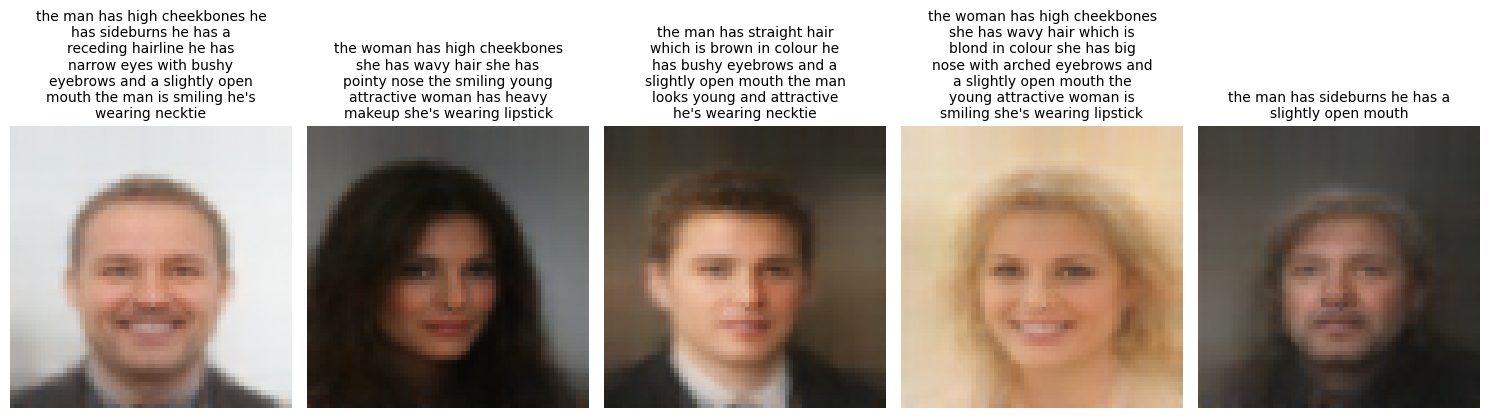

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Generate images using the model
# Assuming 'cvae' is your trained ConditionalVAE model
test_captions = [preprocessed_captions[key] for key in test_sample_keys]

test_captions_tensor = tf.convert_to_tensor(test_captions)

generated_images = cvae.generate(test_captions_tensor, num_samples=len(test_captions_tensor))

# Denormalize the images (transform from [-1, 1] back to [0, 255])
generated_images = (generated_images + 1) * 127.5
generated_images = np.clip(generated_images, 0, 255).astype(np.uint8)

# Detokenize the captions
detokenized_captions = tokenizer.sequences_to_texts(test_captions_tensor.numpy())

# Display the images with captions
fig_width = max(15, 3 * len(detokenized_captions))  # Adjust width based on number of images
fig, axes = plt.subplots(1, len(detokenized_captions), figsize=(fig_width, 6))  # Adjust figure size
if len(detokenized_captions) == 1:
    axes = [axes]  # Ensure axes is iterable

# Wrap text for captions
wrapped_captions = ['\n'.join(textwrap.wrap(caption, width=30)) for caption in detokenized_captions]

for img, caption, ax in zip(generated_images, wrapped_captions, axes):
    ax.imshow(img)
    ax.set_title(caption, fontsize=10)
    ax.axis('off')

plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing
plt.tight_layout()
plt.show()

In [223]:
custom_caption = "the woman sports a 5 o'clock shadow and a mustache"

In [224]:
custom_caption_tokenized = tokenizer.texts_to_sequences([custom_caption])

In [225]:
from keras.preprocessing.sequence import pad_sequences

custom_caption_padded = pad_sequences(custom_caption_tokenized, maxlen=max_caption_length, padding='post')

In [226]:
print(custom_caption_padded)

[[ 2  4 42  5 48 49 50  3  5 69  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]]


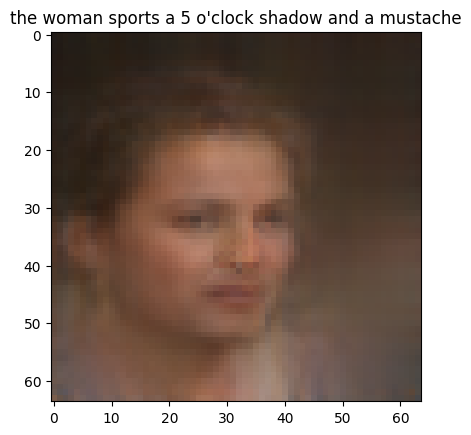

In [247]:
generated = cvae.generate(custom_caption_padded)
generated = (generated + 1) * 127.5

img_to_show = generated[0]

img_to_show = img_to_show.numpy().astype('uint8')

plt.imshow(img_to_show)

plt.title(custom_caption)

plt.show()